# Test Deployed Model

## Import libraries

In [ ]:
import os
import requests
import json

from tensorflow.keras.datasets import mnist
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np

## login into Openshift

In [ ]:
cluster_url = "https://api.smaug.na.operate-first.cloud:6443"

# Using token
token = os.environ["CLUSTER_TOKEN"]
!oc login --token=$token --server=$cluster_url

# # Using credentials
# username = os.environ["USERNAME"]
# password = os.environ["PASSWORD"]
# !oc login -u $username -p $password --insecure-skip-tls-verify $cluster_url

In [11]:
!oc project

Using project "thoth-deployment-examples" on server "https://api.cnv.massopen.cloud:6443".


In [2]:
!oc project thoth-deployment-examples

Now using project "thoth-deployment-examples" on server "https://api.cnv.massopen.cloud:6443".


In [12]:
!oc get pods

NAME                                  READY     STATUS      RESTARTS   AGE
elyra-aidevsecops-tutorial-2-deploy   0/1       Completed   0          12d
elyra-aidevsecops-tutorial-2-wmml6    1/1       Running     0          12d


In [4]:
!oc get routes

NAME                         HOST/PORT                                                                      PATH      SERVICES                     PORT      TERMINATION   WILDCARD
elyra-aidevsecops-tutorial   elyra-aidevsecops-tutorial-thoth-deployment-examples.apps.cnv.massopen.cloud             elyra-aidevsecops-tutorial   <all>                   None


## Test deployed Model

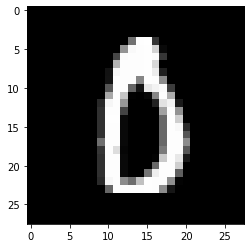

The number in the image is 0 with probability 1.0


In [20]:
USE_PYTORCH = bool(int(os.getenv("TUTORIAL_USE_PYTORCH", 0)))

if USE_PYTORCH:
    # Prepare MNIST data.
    test_data = datasets.MNIST(
        root = './data/raw/pytorch-mnist-dataset', 
        train = False, 
        transform = ToTensor(),
    )

    loaders = {
        'test'  : torch.utils.data.DataLoader(test_data, 
                                            batch_size=1, 
                                            shuffle=True, 
                                            num_workers=1),
    }

    test_data = loaders['test']

    total_tests = int(os.getenv("TUTORIAL_MAX_REQUESTS_TEST", len(test_data)))
else:
    _, (x_test, y_test) = mnist.load_data()

    # Convert to float32.
    x_test = np.array(x_test, np.float32)

    # Normalize images value from [0, 255] to [0, 1].
    x_test = x_test / 255.0

    test_data = zip(x_test, y_test)

    total_tests = int(os.getenv("TUTORIAL_MAX_REQUESTS_TEST", len(x_test)))

addr = os.getenv(
    "THOTH_AIDEVSECOPS_TUTORIAL_MODEL_URL",
    "http://elyra-aidevsecops-tutorial-thoth-deployment-examples.apps.smaug.na.operate-first.cloud",
)
test_url = addr + "/predict"

# prepare headers for http request
headers = {"content-type": "application/json"}

# select one test image
img = test_data[5890][0]
data = json.dumps({"inputs": img.tolist()})

# Check which image is sent
# plt.imshow(img, cmap="gray")
# plt.show(block=False)
# plt.pause(1)
# plt.close()
print(f"Input image number: {test_data[5890][1]}")

# send http request with image and receive response
response = requests.post(test_url, data=data, headers=headers)

# decode response
json_response = response.json()
# {'prediction': 0, 'latency': 0.030432076993747614, 'probability': 1.0}

prediction = json_response["prediction"]
latency = json_response["latency"]
probability = json_response["probability"]

print(
    f"Model predicted {prediction} in {latency} s with probability {probability}"
)